<a href="https://colab.research.google.com/github/genzj/llm-fine-tune-course/blob/main/Lab_03_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 首先修改会话类型为GPU

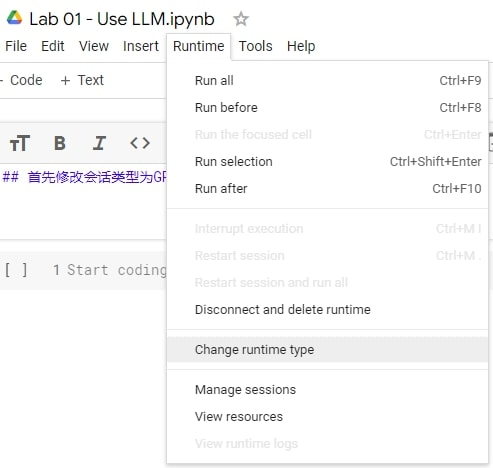

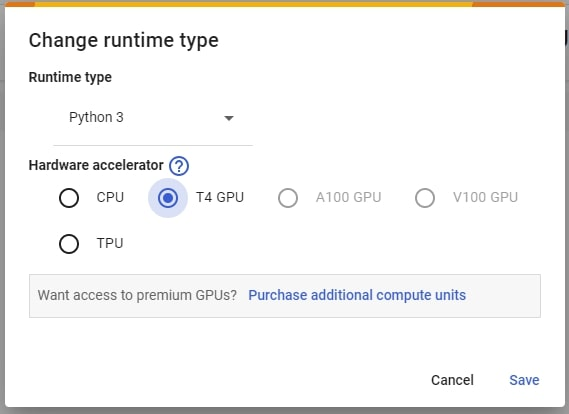

In [ ]:
# 安装依赖库
!pip install transformers==4.31.0 datasets==2.13.0 peft==0.4.0 \
  accelerate==0.21.0 bitsandbytes==0.40.2 trl==0.4.7 mlflow \
  sentencepiece evaluate

## 数据加载

In [ ]:
from datasets import load_dataset
from IPython.display import display, display_markdown
import pandas as pd
import textwrap

In [ ]:
def print_long_string(s: str, width=70):
  print('\n'.join(textwrap.wrap(s, width=width)))

In [ ]:
hellaswag_ds = load_dataset("Rowan/hellaswag")
hellaswag_df = pd.DataFrame(hellaswag_ds['validation'])
display(hellaswag_df.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label
0,24,Roof shingle removal,A man is sitting on a roof.,he,A man is sitting on a roof. he,"[is using wrap to wrap a pair of skis., is rip...",activitynet~v_-JhWjGDPHMY,val,indomain,3
1,92,Clean and jerk,A lady walks to a barbell. She bends down and ...,the lady,A lady walks to a barbell. She bends down and ...,"[swings and lands in her arms., pulls the barb...",activitynet~v_-lJS58hyo1c,val,zeroshot,3
2,106,Canoeing,Two women in a child are shown in a canoe whil...,the child and a different man,Two women in a child are shown in a canoe whil...,[are then shown paddling down a river in a boa...,activitynet~v_-xQvJmC2jhk,val,indomain,2
3,114,High jump,A boy is running down a track.,the boy,A boy is running down a track. the boy,"[runs into a car., gets in a mat., lifts his b...",activitynet~v_-zHX3Gdx6I4,val,zeroshot,2
4,116,High jump,The boy lifts his body above the height of a p...,the boy,The boy lifts his body above the height of a p...,"[turns his body around on the mat., gets up fr...",activitynet~v_-zHX3Gdx6I4,val,zeroshot,1


## 加载模型

In [ ]:
from transformers import LlamaTokenizer, LlamaForCausalLM

In [ ]:
model_path = 'openlm-research/open_llama_3b_v2'
model = LlamaForCausalLM.from_pretrained(
    model_path, device_map='auto',
)

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(model_path)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


1

## 方法一：手动评估

In [ ]:
def remove_special_chars(s):
  return s.replace('[', '').replace(']', '')

def prompt_hellaswag(example):
  ctx = remove_special_chars(example['ctx'])
  endings = [remove_special_chars(ending) for ending in example['endings']]
  prompt = f"Context: {ctx}\nQuestion: Which ending makes the most sense?\n"
  prompt += 'Endings:\n'
  prompt += f"A. {endings[0]}\n"
  prompt += f"B. {endings[1]}\n"
  prompt += f"C. {endings[2]}\n"
  prompt += f"D. {endings[3]}\n"
  prompt += "You may choose from 'A', 'B', 'C', 'D'.\nAnswer:"

  return prompt

print(prompt_hellaswag(hellaswag_df.iloc[5809]))

Context: header How to get perfect eyebrows title Find the place where your brows should begin. step Finding just the right spot for your inner brows to start is key to creating perfect brows, since starting too far in could throw off the balance of your face. To figure out where your inner brows should start, use the following technique : substeps As a general starting point, take a pencil or other long, thin instrument and line it up with the inside corner of your eye.
Question: Which ending makes the most sense?
Endings:
A. It should create a slight curve out the corner. Lower it back into position and not over your eyes.
B. The place where the instrument overlaps your brow is where it should begin. Mark the spot by making a dot there with an eyeliner pencil.
C. Measure the length of your inner brow and the width of your outer brow. Make sure it is inside the outer portion of your eye.
D. Draw a dot just above or just above the inner corner of your eye. Make sure that the lines cros

In [ ]:
hellaswag_df_sample = hellaswag_df.sample(n=5, random_state=42)
display(hellaswag_df_sample)

,ind,activity_label,ctx_a,ctx_b,ctx,endings,source_id,split,split_type,label
5809,19073,Personal Care and Style,[header] How to get perfect eyebrows [title] F...,,[header] How to get perfect eyebrows [title] F...,[It should create a slight curve out the corne...,wikihow~31450,val,zeroshot,1
5938,20017,Personal Care and Style,[header] How to make french knot easy way hair...,,[header] How to make french knot easy way hair...,"[Therefore, it is important to make sure to no...",wikihow~33062,val,zeroshot,1
2260,34560,Sharpening knives,The person puts a new belt on the machine. The...,the person,The person puts a new belt on the machine. The...,[removes the f * * king wheelie and chains the...,activitynet~v_pHAIrx_cRFU,val,zeroshot,2
8834,41427,Family Life,[header] How to plan your own funeral [title] ...,,[header] How to plan your own funeral [title] ...,"[Then, come up with ideas for different funera...",wikihow~68173,val,zeroshot,2
4513,9755,Health,[header] How to buy an exercise bike [title] E...,,[header] How to buy an exercise bike [title] E...,[[title] Choose an upright bike for low impact...,wikihow~16080,val,indomain,0


In [ ]:
test_strings = hellaswag_df_sample.apply(prompt_hellaswag, axis=1).to_list()
predictions = []
for test in test_strings:
  input_ids = tokenizer(test, return_tensors="pt").input_ids.to('cuda')

  generation_output = model.generate(
      input_ids=input_ids, max_new_tokens=1
  )
  predictions.append(tokenizer.decode(generation_output[0]))

In [ ]:
for i in range(len(predictions)):
  display_markdown('## Example {}'.format(i), raw=True)
  print(predictions[i])
  print()
  display_markdown('### Answer: ', raw=True)
  print(predictions[i][-1:])
  print()
  display_markdown('### Truth: ', raw=True)
  label_idx = int(hellaswag_df_sample.iloc[i].label)
  print('ABCD'[label_idx])
  display_markdown('---', raw=True)


## Example 0

<s>Context: header How to get perfect eyebrows title Find the place where your brows should begin. step Finding just the right spot for your inner brows to start is key to creating perfect brows, since starting too far in could throw off the balance of your face. To figure out where your inner brows should start, use the following technique : substeps As a general starting point, take a pencil or other long, thin instrument and line it up with the inside corner of your eye.
Question: Which ending makes the most sense?
Endings:
A. It should create a slight curve out the corner. Lower it back into position and not over your eyes.
B. The place where the instrument overlaps your brow is where it should begin. Mark the spot by making a dot there with an eyeliner pencil.
C. Measure the length of your inner brow and the width of your outer brow. Make sure it is inside the outer portion of your eye.
D. Draw a dot just above or just above the inner corner of your eye. Make sure that the lines c

### Answer: 

C



### Truth: 

B


---

## Example 1

<s>Context: header How to make french knot easy way hair style title Work with second day hair. step While some hairstyles may work best with freshly washed, perfectly clean hair, the french knot actually works best with slightly dirty hair. When hair is immaculately clean, it's often silky and hard to hold in place.
Question: Which ending makes the most sense?
Endings:
A. Therefore, it is important to make sure to not pull to create frizz before styling. substeps Instead, prioritize washing hair at the end of every day instead of just when you wake up to style.
B. While satin hair is often nice, it will slide out of your pins and the hairstyle won't hold for the entire day. Hair that hasn't been washed in a day or two will be full of natural oils that will help you create a shape that stays.
C. substeps To begin with, you'll have some hair in the french knot. Start by getting some hair out of the french knot.
D. For this reason, french knot style hair will be missing hair that was was

### Answer: 

B



### Truth: 

B


---

## Example 2

<s>Context: The person puts a new belt on the machine. The person sharpents the blade on the second belt. The person takes the second belt off. the person
Question: Which ending makes the most sense?
Endings:
A. removes the f * * king wheelie and chains the things up.
B. puts the sword back on the machine.
C. puts on a third belt.
D. removes the belt and smooths out the new belt.
You may choose from 'A', 'B', 'C', 'D'.
Answer: C



### Answer: 

C



### Truth: 

C


---

## Example 3

<s>Context: header How to plan your own funeral title Make a list of your likes and dislikes. step Take out a pen and some paper and begin brainstorming ideas regarding your funeral. Write down whatever comes to mind, at least at first.
Question: Which ending makes the most sense?
Endings:
A. Then, come up with ideas for different funeral traditions (including : substeps People from different backgrounds a place to put the ashes for the deceased. Did she like listening to her favorite music or watching a movie? People from different religions maybe.
B. title Prepare for your funeral by creating a family obituary. step By visiting your funeral home to have them draw up a letter informing you what they wish to say, they can write the letter at bedtime.
C. You might include things that you've seen done at other funerals that you though worked well. substeps As you are sketching out ideas, pay attention to the intangibles as well.
D. It might be something simple like the experience of sitt

### Answer: 

A



### Truth: 

C


---

## Example 4

<s>Context: header How to buy an exercise bike title Estimate how often you will use the bike. step Upright bikes are easy to use and provide great cardiovascular workouts. They work abdominal muscles since you are keeping the body upright, and they offer upper body arm workout.
Question: Which ending makes the most sense?
Endings:
A. title Choose an upright bike for low impact cardio. step A spin bike most closely resembles the " real " activity of riding a road bike.
B. They get you working less because you are doing cardio. substeps Running is another great way to warm up your lungs and run faster.
C. Your bike may not provide the same muscle tone as stationary bikes, but you will run 1-2 miles (3.0 km) of cardio a day. title Read reddit's online workout chapters to learn more.
D. You will want to check with your trainer before you begin to ride the bike. You might also want to think about shipping your bike.
You may choose from 'A', 'B', 'C', 'D'.
Answer: A



### Answer: 

A



### Truth: 

A


---

## 方法二：使用Hugging Face框架

### 定义Pipeline

In [ ]:
from transformers import pipeline

In [ ]:
pipe = pipeline('text-generation', model=model, tokenizer=tokenizer)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
response = pipe(prompt_hellaswag(hellaswag_df.iloc[5809]), max_new_tokens=1)
print(response)

[{'generated_text': "Context: header How to get perfect eyebrows title Find the place where your brows should begin. step Finding just the right spot for your inner brows to start is key to creating perfect brows, since starting too far in could throw off the balance of your face. To figure out where your inner brows should start, use the following technique : substeps As a general starting point, take a pencil or other long, thin instrument and line it up with the inside corner of your eye.\nQuestion: Which ending makes the most sense?\nEndings:\nA. It should create a slight curve out the corner. Lower it back into position and not over your eyes.\nB. The place where the instrument overlaps your brow is where it should begin. Mark the spot by making a dot there with an eyeliner pencil.\nC. Measure the length of your inner brow and the width of your outer brow. Make sure it is inside the outer portion of your eye.\nD. Draw a dot just above or just above the inner corner of your eye. Ma

In [ ]:
response = pipe(
    hellaswag_df_sample.apply(prompt_hellaswag, axis=1).to_list(),
    max_new_tokens = 1,
    return_full_text=False
)
print(response)

[[{'generated_text': ' C'}], [{'generated_text': ' B'}], [{'generated_text': ' C'}], [{'generated_text': ' A'}], [{'generated_text': ' C'}]]


### 定义评估指标

In [ ]:
import evaluate
accuracy_metric = evaluate.load("accuracy")

In [ ]:
def parse_response(response):
  ans = response[0]['generated_text'].strip()[0]
  return 'ABCD'.find(ans)

response = pipe(
    hellaswag_df_sample.apply(prompt_hellaswag, axis=1).to_list(),
    max_new_tokens = 1,
    return_full_text=False,
)

preferences = hellaswag_df_sample['label'].astype(int).to_list()
predictions = [parse_response(r) for r in response]

display(preferences)
display(predictions)
display(accuracy_metric.compute(predictions=predictions, references=preferences))

[1, 1, 2, 2, 0]

[2, 1, 2, 0, 2]

{'accuracy': 0.4}

In [ ]:
metrics = evaluate.combine(["recall", "precision", "f1"])
metrics.compute(predictions=predictions, references=preferences, average="macro")

{'recall': 0.3333333333333333,
 'precision': 0.4444444444444444,
 'f1': 0.35555555555555557}

## 方法三：使用第三方库

In [ ]:
import evaluate

In [ ]:
suite = evaluate.EvaluationSuite.load("SUSTech/tlem")
display(suite.supported_datasets)
suite.load("hellaswag")  # You can check the available datasets by suite.supported_datasets


['arc',
 'hellaswag',
 'mmlu-chat',
 'winogrande',
 'gsm8k',
 'cmmlu-chat',
 'ceval-chat',
 'bbh',
 'drop',
 'MATH']

In [ ]:
@suite.utils.sync_pipe
def predict(msg):
  input_ids = tokenizer(msg, return_tensors="pt").input_ids.to('cuda')
  generation_output = model.generate(
      input_ids=input_ids, max_new_tokens=1
  )
  prediction = tokenizer.decode(generation_output[0])
  return prediction[-1:]


In [ ]:
suite.run(predict)

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset hellaswag downloaded and prepared to /root/.cache/huggingface/datasets/Rowan___hellaswag/validation/0.1.0/512a66dd8b1b1643ab4a48aa4f150d04c91680da6a4096498a5e5f799623d5ae. Subsequent calls will reuse this data.


{'hellaswag': defaultdict(list, {'validation': 0.16351324437363074})}